In [1]:
library(tidyverse)
library(ggplot2)
library(data.table)
library(ggrepel)
library(UpSetR)
library(vroom)
library(rmeta)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘vroom’


The following objects are masked

In [2]:
# This is only needed for motif disruption plots, and only some for actual plotting
library(motifbreakR)
suppressPackageStartupMessages(library(MotifDb))
suppressPackageStartupMessages(library(BSgenome))
suppressPackageStartupMessages(library("BSgenome.Hsapiens.UCSC.hg38"))

Loading required package: grid

Loading required package: MotifDb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objec

### Run this first

In [4]:
cell_types <- c('acinar','alpha','beta','bulk','delta','ductal','endothelial','gamma','immune','stellate')

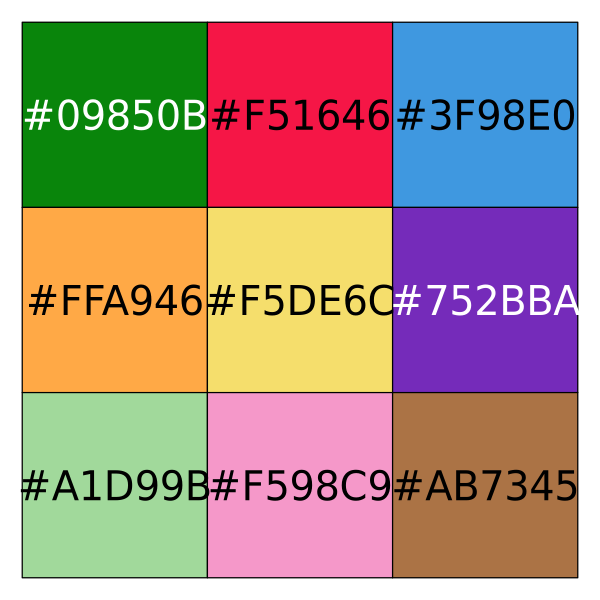

In [5]:
major_colors = c('acinar'='#09850B', 'alpha'='#F51646', 'beta'='#3F98E0',
                 'delta'='#FFA946', 'ductal'='#F5DE6C', 'endothelial'='#752BBA', 
                 'gamma'='#A1D99B', 'immune'='#F598C9', 'stellate'='#AB7345')
options(repr.plot.width=5, repr.plot.height=5)
scales::show_col(major_colors, cex_label=2)

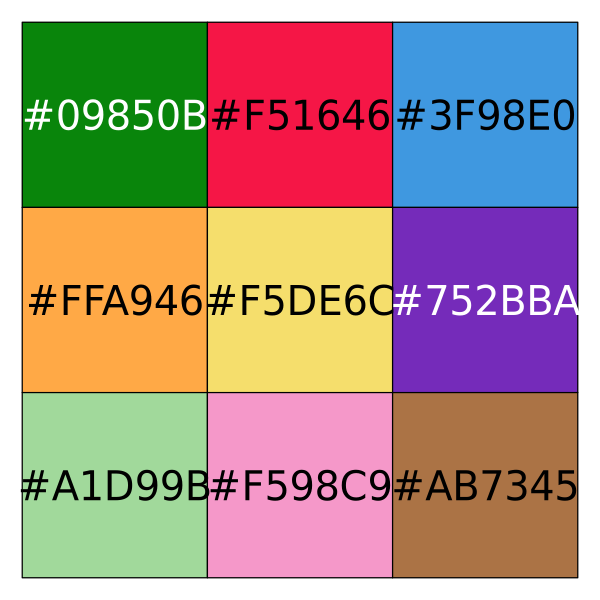

In [6]:
major_colors_caps = c('Acinar'='#09850B', 'Alpha'='#F51646', 'Beta'='#3F98E0',
                 'Delta'='#FFA946', 'Ductal'='#F5DE6C', 'Endothelial'='#752BBA', 
                 'Gamma'='#A1D99B', 'Immune'='#F598C9', 'Stellate'='#AB7345')
options(repr.plot.width=5, repr.plot.height=5)
scales::show_col(major_colors_caps, cex_label=2)

In [7]:
fig_dir <- '/path/to/caQTL/stuff/figures/'

# 3A - caQTL Peaks by ct

In [7]:
#caqtl_full_summary_stats <- vroom('/path/to/caQTL/stuff/caQTLs_rasqual/Summary_allCells_all_run1F.tsv')
#
#cell_type_significance <- pivot_wider(select(caqtl_full_summary_stats, Feature, rsID, cell, flag_fdr05),
#                          names_from=cell, values_from=flag_fdr05)
#cell_type_significance <- select(cell_type_significance, -endothelial, -immune, -stellate)
#
#feature_ct_significance <- select(cell_type_significance, -rsID) %>%
#    group_by(Feature) %>%
#    summarise_all(any)
#
#counts_by_ct <- data.frame()
#
#main_cell_types <- c('acinar','alpha','beta','delta','ductal','gamma')
#
#for (cell in main_cell_types) {
#    ct_counts <- select(feature_ct_significance, any_of(cell), bulk) %>%
#        table()
#    
#    ct_counts
#    
#    counts_by_ct <- rbind(counts_by_ct, c(cell,ct_counts[2,]))
#    counts_by_ct
#}
#
#colnames(counts_by_ct) <- c("cell", "Not.Bulk",'Bulk')
#
#counts_by_ct$cell <- str_to_title(counts_by_ct$cell)
#counts_by_ct$Bulk <- as.integer(counts_by_ct$Bulk)
#counts_by_ct$Not.Bulk <- as.integer(counts_by_ct$Not.Bulk)
#
#counts_by_ct <- dplyr::arrange(counts_by_ct, -Bulk)
#counts_by_ct$cell <- factor(counts_by_ct$cell, levels=counts_by_ct$cell)
#
#write.table(counts_by_ct, paste0(fig_dir,'3a_data_significant_features_by_cell_type.tsv'),
#           col.names=T, row.names=F, quote=F, sep='\t')

png 
  2

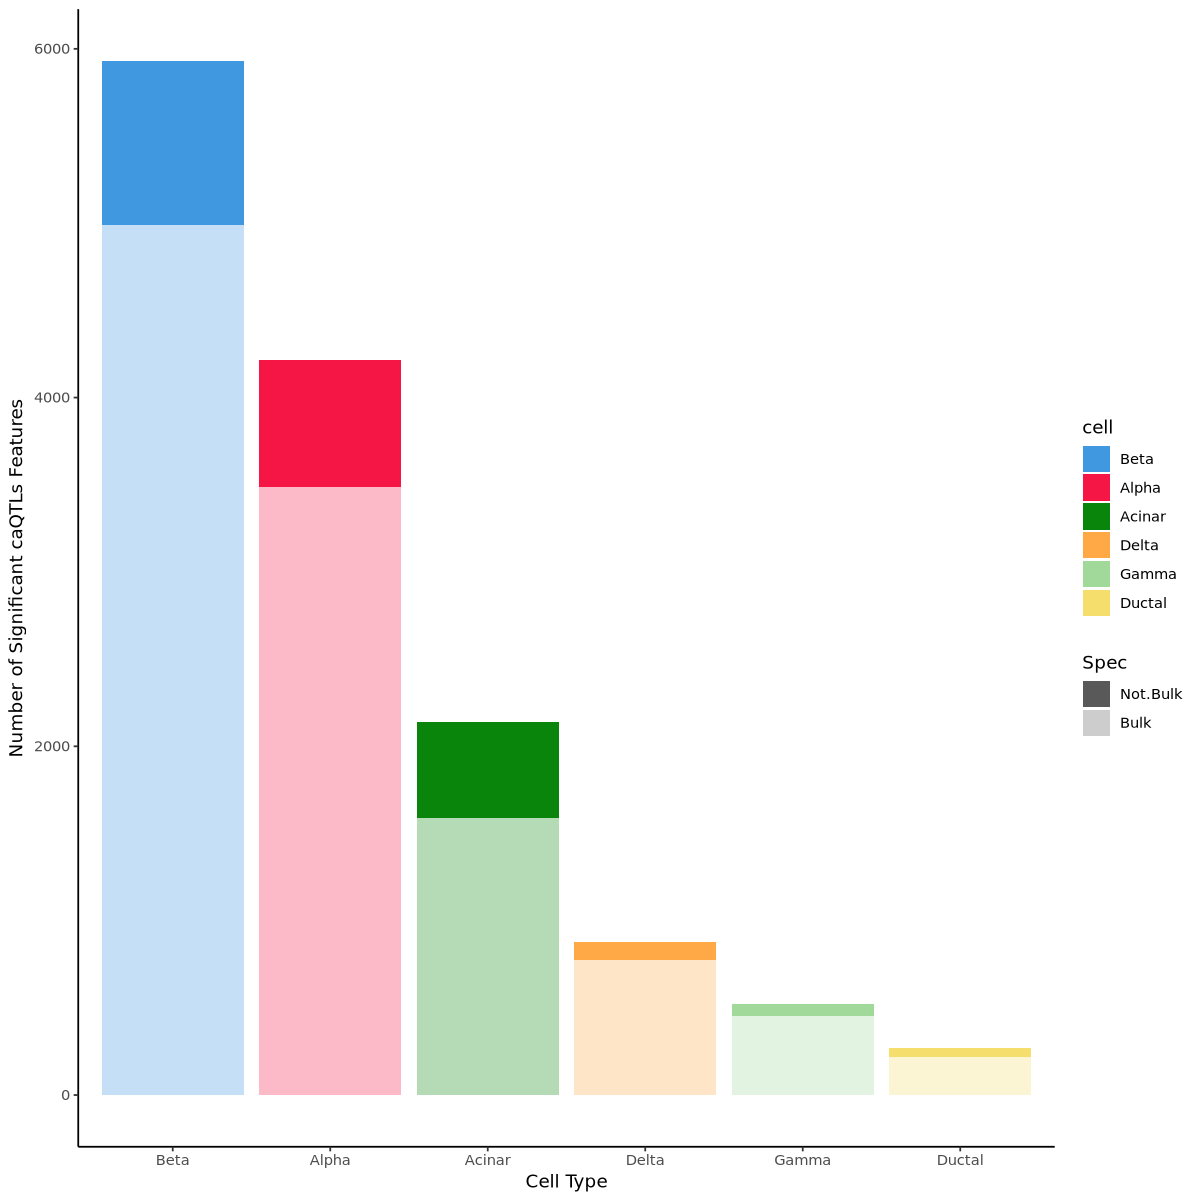

In [8]:
counts_by_ct <- read.table(paste0(fig_dir,'3a_data_significant_features_by_cell_type.tsv'),
           header=T, sep='\t')
counts_by_ct <- arrange(counts_by_ct, -Bulk)
counts_by_ct$cell <- factor(counts_by_ct$cell, levels=counts_by_ct$cell)

counts_by_ct_long <- pivot_longer(counts_by_ct, contains('Bulk'), values_to='Freq', names_to='Spec')
counts_by_ct_long$Spec <- factor(counts_by_ct_long$Spec, levels=c('Not.Bulk','Bulk'))



# Plot dotplot with ggplot -- text labels, no legend

options(repr.plot.width=10, repr.plot.height=10)
p1 <- ggplot(counts_by_ct_long, aes(x=cell, y=Freq, alpha=Spec)) + 
        geom_col(aes(fill=cell)) + 
        labs(x = "Cell Type", y = "Number of Significant caQTLs Features") + 
        scale_fill_manual(values=major_colors_caps) + 
        scale_alpha_manual(values=c(1, 0.3)) +
        theme(axis.text.x=element_text(angle=45, size=20, vjust=0.5),
        axis.text.y=element_text(size=20, vjust=0.5),
        axis.title.x = element_text(size=25, vjust=-0.35),
        axis.title.y = element_text(size=25, vjust=0.5),
        plot.title = element_text(size=25, hjust=0.5, face="bold")) +
        theme_classic()
p1

fp <- paste0(fig_dir,'3a_significant_features_by_cell_type.svg')
svg(fp, width=10, height=10)
p1
dev.off()

# 3b - Variants in Features

Rows: 773267 Columns: 34
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): Feature, rsID, Chromosome, Ref, Alt, cell, feature_snp
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (5): flag_fdr10, flag_fdr05, flag_fdr01, exclude, qtl

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 773267     34

Feature,rsID,Chromosome,position,Ref,Alt,Af,HWEChi_square,IA,Log10_qval,⋯,r2_rSNP,P_VAl,dist,flag_fdr10,flag_fdr05,flag_fdr01,cell,exclude,qtl,feature_snp
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<lgl>,<chr>
chr6:32622377-32623439,chr6:32620608:T:A,chr6,32620608,T,A,0.425926,2.231991,0.998678,-67.03611,⋯,0.824496,8.976233e-71,-2300,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr6:32622377-32623439_chr6:32620608:T:A
chr9:6931452-6932441,chr9:6929401:T:A,chr9,6929401,T,A,0.333333,0.750000,0.993936,-36.60879,⋯,0.985795,1.925609e-38,-2545,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr9:6931452-6932441_chr9:6929401:T:A
chr4:7164816-7165698,chr4:7160692:T:C,chr4,7160692,T,C,0.277778,0.006391,0.999935,-32.46831,⋯,0.902371,1.502522e-34,-4565,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr4:7164816-7165698_chr4:7160692:T:C
chr9:93230239-93231938,chr9:93231475:G:A,chr9,93231475,G,A,0.222222,0.137755,0.999392,-30.83427,⋯,0.992117,3.105136e-32,387,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr9:93230239-93231938_chr9:93231475:G:A
chr17:76968760-76970675,chr17:76972946:C:A,chr17,76972946,C,A,0.296296,0.337734,0.980182,-29.73370,⋯,0.940828,4.969777e-32,3228,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr17:76968760-76970675_chr17:76972946:C:A
chr21:13979625-13980808,chr21:13980560:G:C,chr21,13980560,G,C,0.314815,0.083599,0.930667,-27.70426,⋯,0.870565,7.793799e-30,344,TRUE,TRUE,TRUE,acinar,FALSE,TRUE,chr21:13979625-13980808_chr21:13980560:G:C


png 
  2

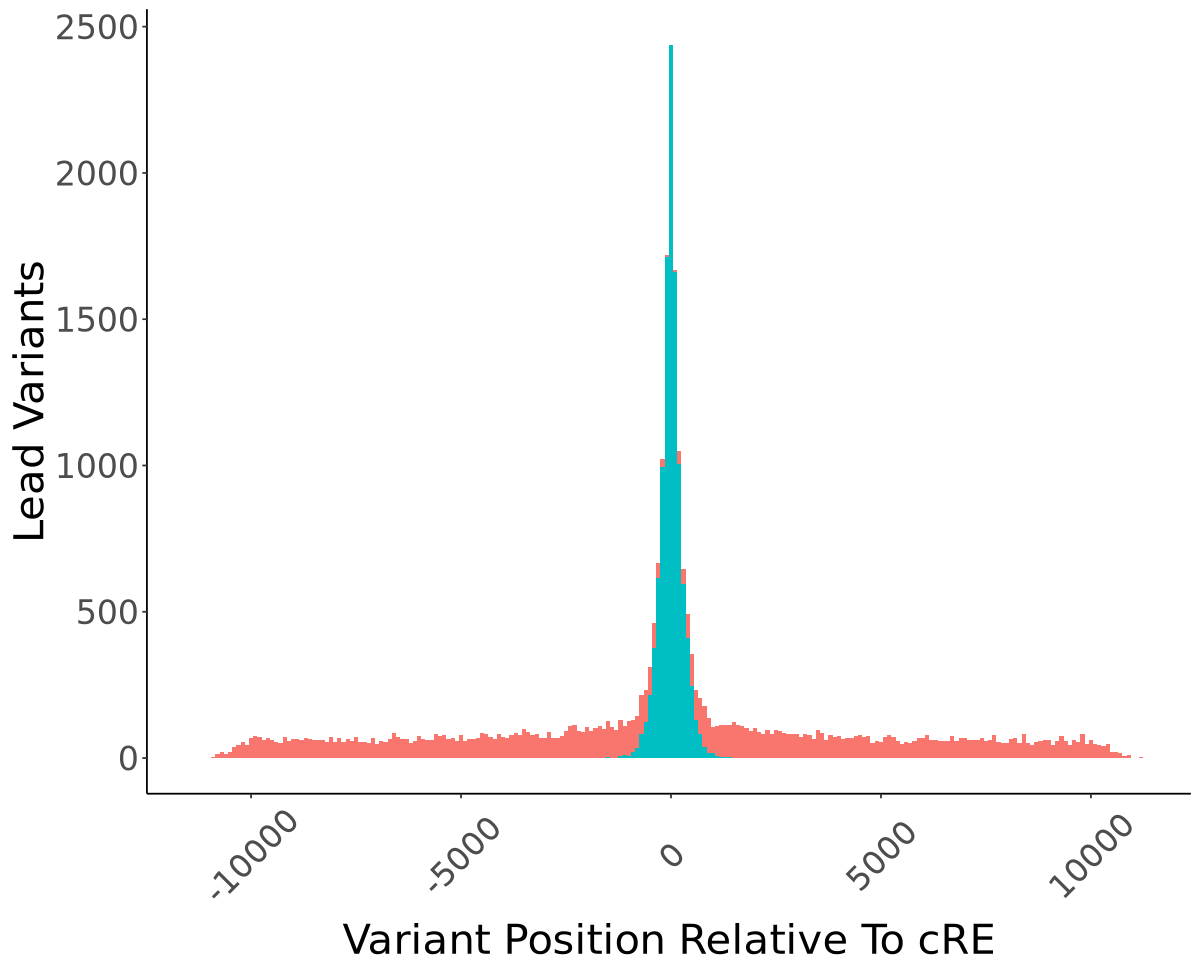

In [9]:
caqtl_lead_summary_stats <- vroom('/path/to/caQTL/stuff/caQTLs_rasqual/Summary_allCells_leads_run1F.tsv')
caqtl_lead_summary_stats$peak_start <- as.numeric(str_split(str_split(caqtl_lead_summary_stats$Feature, ":", simplify=T)[,2],
                                                      "-", simplify=T)[,1])
caqtl_lead_summary_stats$peak_end <- as.numeric(str_split(str_split(caqtl_lead_summary_stats$Feature, ":", simplify=T)[,2],
                                                      "-", simplify=T)[,2])
caqtl_lead_summary_stats$in_peak <- (caqtl_lead_summary_stats$peak_start < caqtl_lead_summary_stats$position) &
                                    (caqtl_lead_summary_stats$peak_end > caqtl_lead_summary_stats$position)

options(repr.plot.width=10, repr.plot.height=8)
p1 <- ggplot(filter(caqtl_lead_summary_stats, flag_fdr05), aes(x=dist, fill=in_peak)) + 
    geom_histogram(binwidth=100) + theme_classic() + 
    theme(axis.text.x=element_text(angle=45, size=20, vjust=0.5),
    axis.text.y=element_text(size=20, vjust=0.5),
    axis.title.x = element_text(size=25, vjust=-0.35),
    axis.title.y = element_text(size=25, vjust=0.5),
    plot.title = element_text(size=25, hjust=0.5, face="bold"),
    legend.position='none') +
    ylab("Lead Variants") + xlab("Variant Position Relative To cRE")
p1

fp <- paste0(fig_dir,'3b_variants_in_features.svg')
svg(fp, width=10, height=8) # I haven't optomized the dimensions for this yet
p1
dev.off()

# 3c - Specificity

In [10]:
#mash <- data.frame(read.table('/path/to/caQTL/stuff/anova_interaction/240111_WE_run1_all_ash_pca_canonical_mash_lfsr.tsv', 
#                                  header=T, sep='\t') < 0.05)
#mash$cre <- stringr::str_split(rownames(mash), '::', simplify=T)[,1]
#
#dim(mash)
#
#upset_data <- group_by(mash, cre) %>%
#    summarise_all(any) %>%
#    tibble::column_to_rownames(var='cre') %>%
#    mutate_all(as.numeric)
#
#head(upset_data)
#
#write.table(upset_data, paste0(fig_dir,'3c_data_caQTL_specificity.tsv'), sep='\t', col.names=T, row.names=T, quote=F)

png 
  2

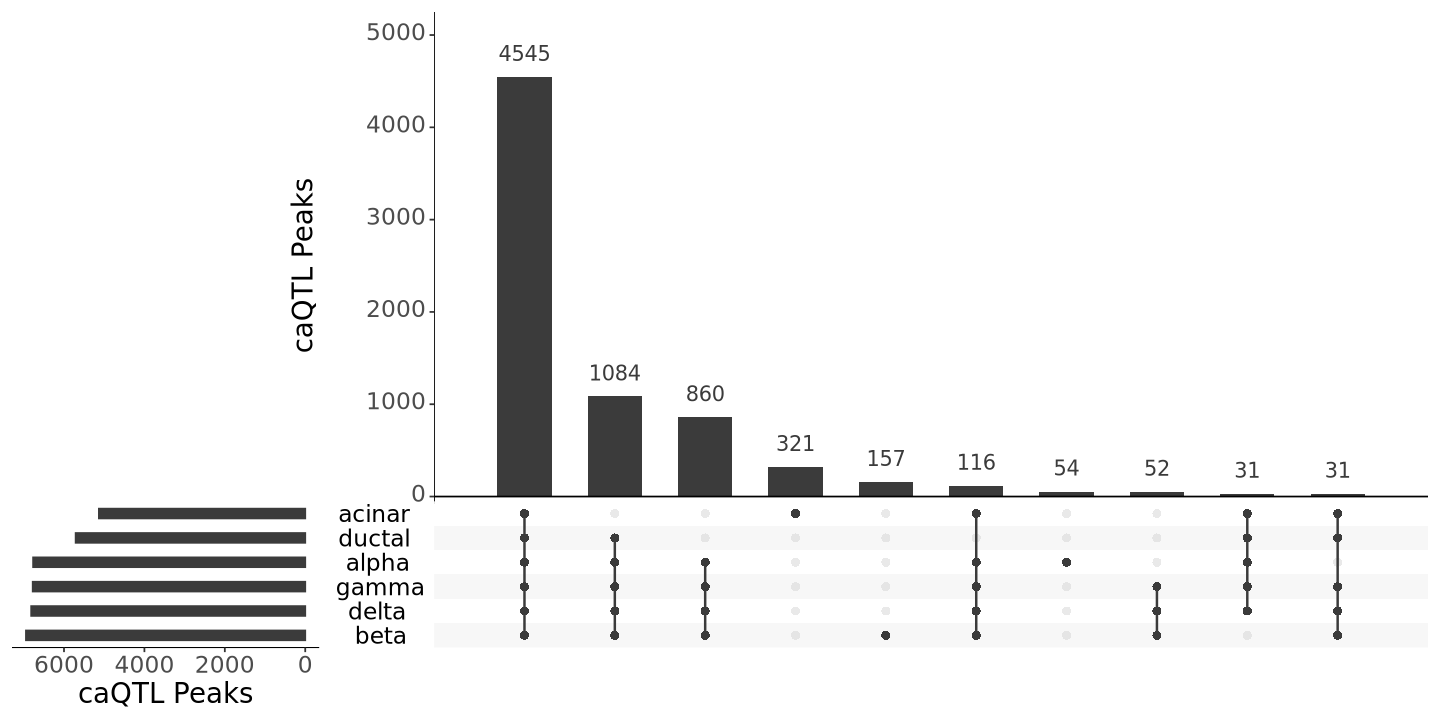

In [11]:
upset_data <- read.table(paste0(fig_dir,'3c_data_caQTL_specificity.tsv'), sep='\t', header=T)

options(repr.plot.width=12, repr.plot.height=6)
upset(upset_data, nsets=6, order.by = "freq", nintersects=10, text.scale=2,
      mainbar.y.label='caQTL Peaks', sets.x.label='caQTL Peaks')

fp <- paste0(fig_dir,'3c_caQTL_specificity.svg')
svg(fp, width=12, height=6, onefile=F)
upset(upset_data, nsets=6, order.by = "freq", nintersects=10, text.scale=2,
      mainbar.y.label='caQTL Peaks', sets.x.label='caQTL Peaks')
dev.off()

# 3d - Opposing Effects Example

In [12]:
#genotypes = read.table("/path/to/caQTL/stuff/caQTLs_rasqual/genotypes/All_tested_genotypes_run1.tsv", header=T)
#
#samples_all = c('R207','R217','R218','R221','R223','R226','R228','R234','R237','R238','R246','R247','R275',
#                'R284','R290','R292','R316','R317','R319','R325','R326','R327','R332','R353','R354','R362','R363')
#
#cpm_dir <- "/path/to/peaks/recluster_final_clustering_v2/"
#
#cpm_dir_files <- list.files(cpm_dir)
#cpm_dir_files[str_detect(cpm_dir_files, 'CPM')]
#
#cpm <- NULL
#for (c in main_cell_types) {
#    cpm_load <- read.table(paste0(cpm_dir, c, "_CPM_persample.txt"), header=T, row.names=1)
#    cell_specific_samples <- unlist(read.table(paste0('/path/to/caQTL/stuff/atac_cell_type_matrices/samples.',c,'.csv'), sep=','))
#    cpm_load <- cpm_load[cell_specific_samples]
#    
#    colnames(cpm_load) <- paste0(colnames(cpm_load),".",c)
#    if (is.null(cpm)) {
#        cpm <- cpm_load
#    } else {
#        cpm <- cbind(cpm, cpm_load)
#    }
#}
#
#rownames(cpm) <- str_replace(rownames(cpm), "-",":")
#
#celltypes <- c('acinar','alpha','beta','delta','ductal','endothelial','gamma',
#                'immune','stellate')
#celltypes_to_graph_bulk <- c('acinar','alpha','beta','delta','ductal','gamma', 'bulk')
#
#codir = '/data/covariates/'
#
#meta = read.table(paste0(codir, 'metadata'), sep="\t", header=T)
#meta = meta[match(samples_all, meta$Record.ID),]
#
#info = data.frame(celltype = sort(rep(celltypes, length(samples_all))), sample_name = rep( samples_all,length(celltypes)), 
#                  samp_cell = paste(rep (samples_all,length(celltypes)), sort(rep(celltypes, length(samples_all))) , sep="."),
#                   age = rep(meta$Age., length(celltypes)), sex = rep(meta$Sex.,length(celltypes)))
#
#rownames(info) <- info$samp_cell
#info <- info[colnames(cpm),]
#info <- dplyr::filter(info, celltype %in% celltypes_to_graph_bulk)

In [13]:
#gene_id = 'chr15:70140098-70143608'
#snp_id  = 'chr15:70140778:G:C'
#
#feature_snp <- paste0(gene_id, "_",snp_id)
#
#specific_cpm <- data.frame(cpm=t(cpm[gene_id,])[,1], samp_cell = rownames(t(cpm[gene_id,])))
#specific_geno <- data.frame(genotype=t(genotypes[snp_id,])[,1], sample_name=rownames(t(genotypes[snp_id,])))
#sample_data <- left_join(left_join(info, specific_cpm), specific_geno)
#
#ref <- str_split(snp_id,":", simplify=T)[,3]
#alt <- str_split(snp_id,":", simplify=T)[,4]
#sample_data$locus_genotypes <- sample_data$genotype
#sample_data$locus_genotypes <- str_replace(sample_data$locus_genotypes, "0", paste0(ref,ref))
#sample_data$locus_genotypes <- str_replace(sample_data$locus_genotypes, "1", paste0(ref,alt))
#sample_data$locus_genotypes <- str_replace(sample_data$locus_genotypes, "2", paste0(alt,alt))
#sample_data$locus_genotypes <- factor(sample_data$locus_genotypes, levels=c(paste0(ref,ref), paste0(ref,alt),paste0(alt,alt)))
#
#sample_data$celltype <- str_to_title(sample_data$celltype)
#
#write.table(sample_data, paste0(fig_dir,'3d_data_opposing_boxplot.tsv'), sep='\t', col.names=T, row.names=T, quote=F)

png 
  2

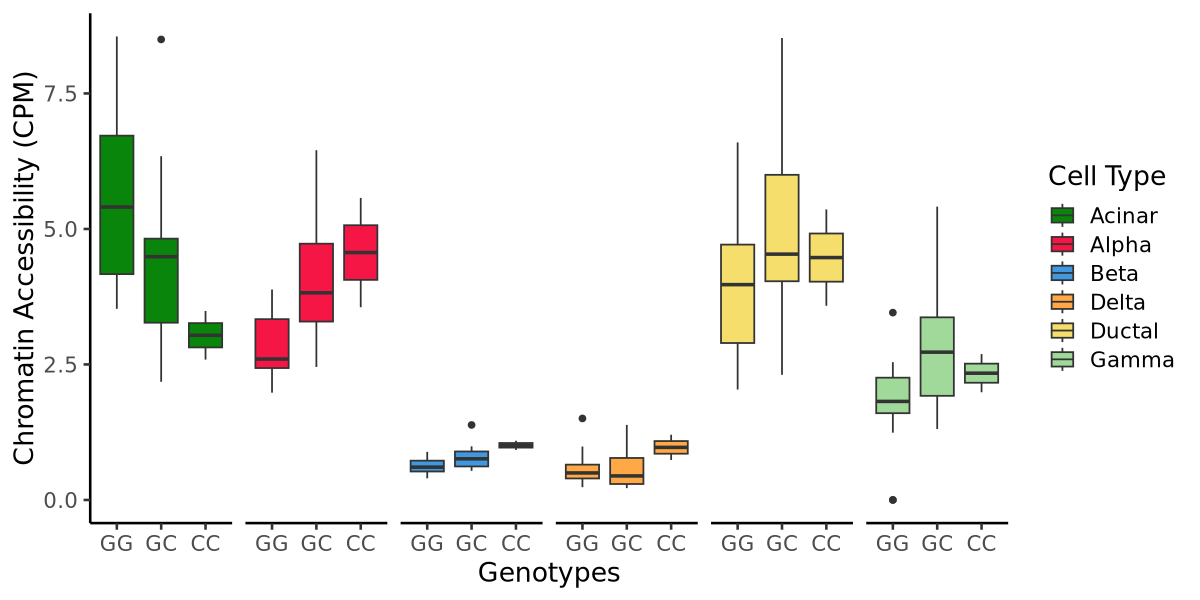

In [14]:
sample_data <- read.table(paste0(fig_dir,'3d_data_opposing_boxplot.tsv'), sep='\t', header=T)
sample_data$locus_genotypes <- factor(sample_data$locus_genotypes, levels=c('GG','GC','CC'))

options(repr.plot.width=10, repr.plot.height=5)
p1 <- ggplot(sample_data, aes(x=locus_genotypes, y=cpm, fill=celltype)) +
    geom_boxplot() + facet_grid(.~ celltype) + theme_classic(base_size=16) +
    scale_fill_manual(values=major_colors_caps) + ylab("Chromatin Accessibility (CPM)") + 
    xlab('Genotypes') + labs(fill="Cell Type") + theme(strip.background = element_blank(),
                             strip.text.y = element_blank(), strip.text.x = element_blank()) 
p1

fp <-paste0(fig_dir,'3d_opposing_boxplot.svg')
svg(fp, width=10, height=5)
p1
dev.off()

# 3e - Number of Motifs by cell type overall

In [15]:
#binom_p.values <- read.table('/path/to/caQTL/stuff/motifs/Binomial.p_values_inpeaks_Run1F.csv',
#          sep=',', header=T, row.names=1)
#bh_corrected_motif_p.values = apply(binom_p.values, 2, p.adjust, method = "BH")
#head(bh_corrected_motif_p.values)
#
#motifs_sig <- data.frame(sig=colSums(bh_corrected_motif_p.values<0.05), cell=str_to_title(names(colSums(bh_corrected_motif_p.values<0.05))))
#
#head(motifs_sig)
#
#write.table(motifs_sig, paste0(fig_dir,'3d_data_motifs_by_ct.tsv'), sep='\t', col.names=T, row.names=T, quote=F)

png 
  2

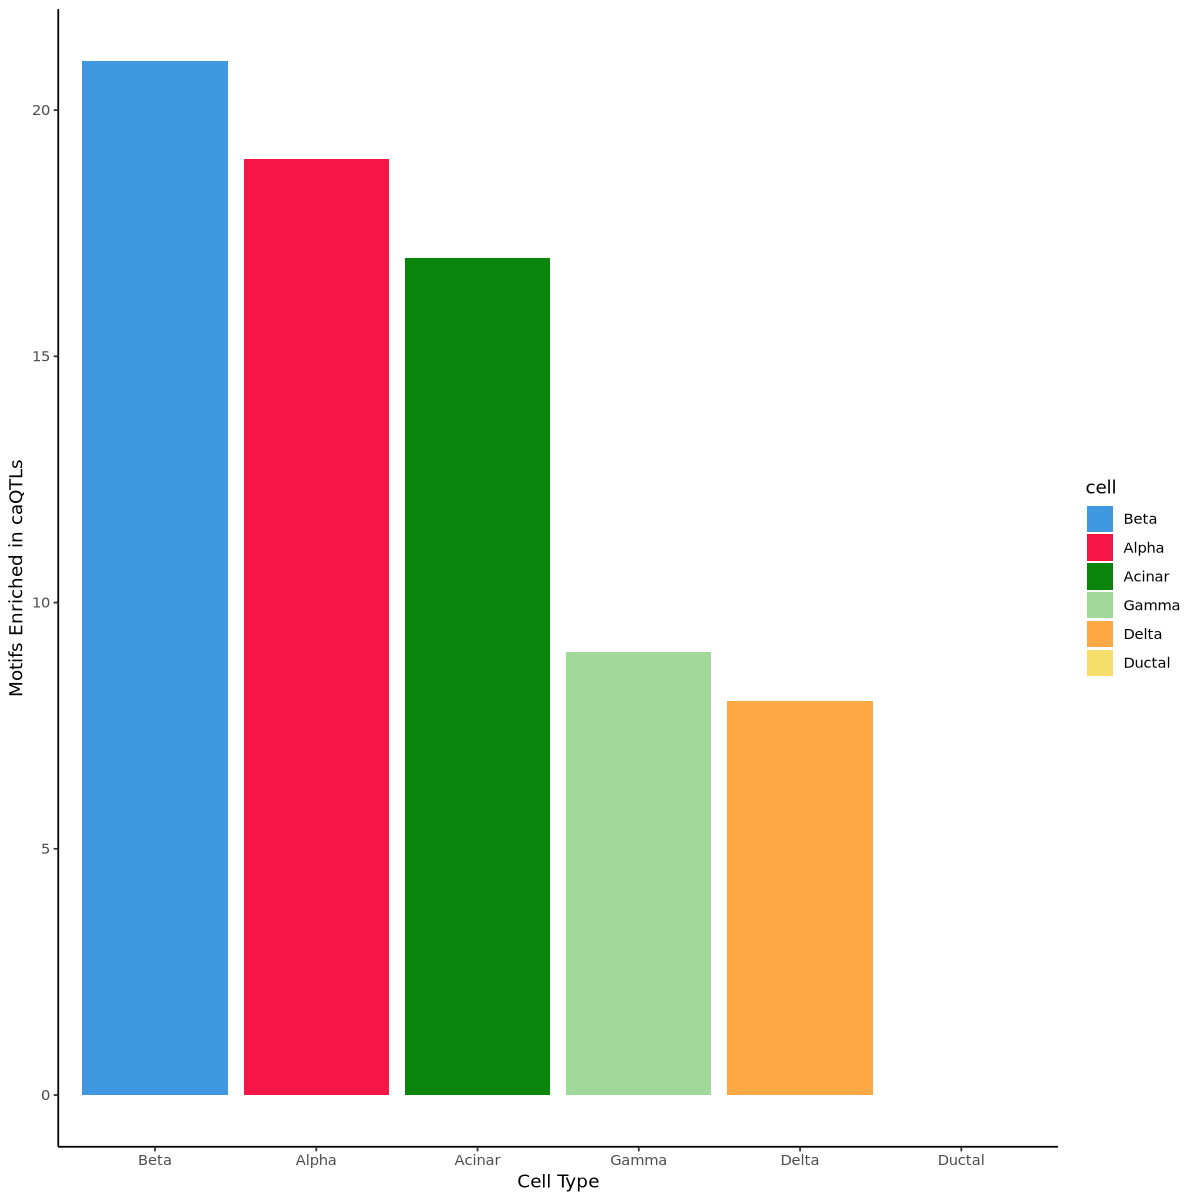

In [16]:
# Plot dotplot with ggplot -- text labels, no legend

motifs_sig <- read.table(paste0(fig_dir,'3d_data_motifs_by_ct.tsv'), sep='\t', header=T)
motifs_sig <- arrange(motifs_sig, -sig)
motifs_sig$cell <- factor(motifs_sig$cell, levels=motifs_sig$cell)


options(repr.plot.width=10, repr.plot.height=10)
p1 <- ggplot(filter(motifs_sig, cell != 'Bulk'), aes(x=cell, y=sig)) + 
        geom_col(aes(fill=cell)) + 
        labs(x = "Cell Type", y = "Motifs Enriched in caQTLs") + 
        scale_fill_manual(values=major_colors_caps) + 
        #scale_y_discrete(expand = c(0, 0), limits=c(0,2500,5000,7500,10000, 12500, 15000), breaks=c(0,2500,5000,7500,10000, 12500, 15000)) + 
        theme(plot.title=element_text(hjust=0.5,size=25),
              axis.title=element_text(size=20),
              axis.text.y=element_text(size=15),
              axis.text.x=element_text(angle=45, size=15, hjust=1),
              axis.ticks=element_blank(),
              legend.position = "none") +
        theme_classic()
p1

fp <-paste0(fig_dir,'3e_motifs_by_ct.svg')
svg(fp, width=10, height=10)
p1
dev.off()

# 3f - Motifs changing in beta cells

Warning message:
"Removed 521 rows containing missing values or values outside the scale range (`geom_text_repel()`)."
Warning message:
"Removed 521 rows containing missing values or values outside the scale range (`geom_text_repel()`)."


png 
  2

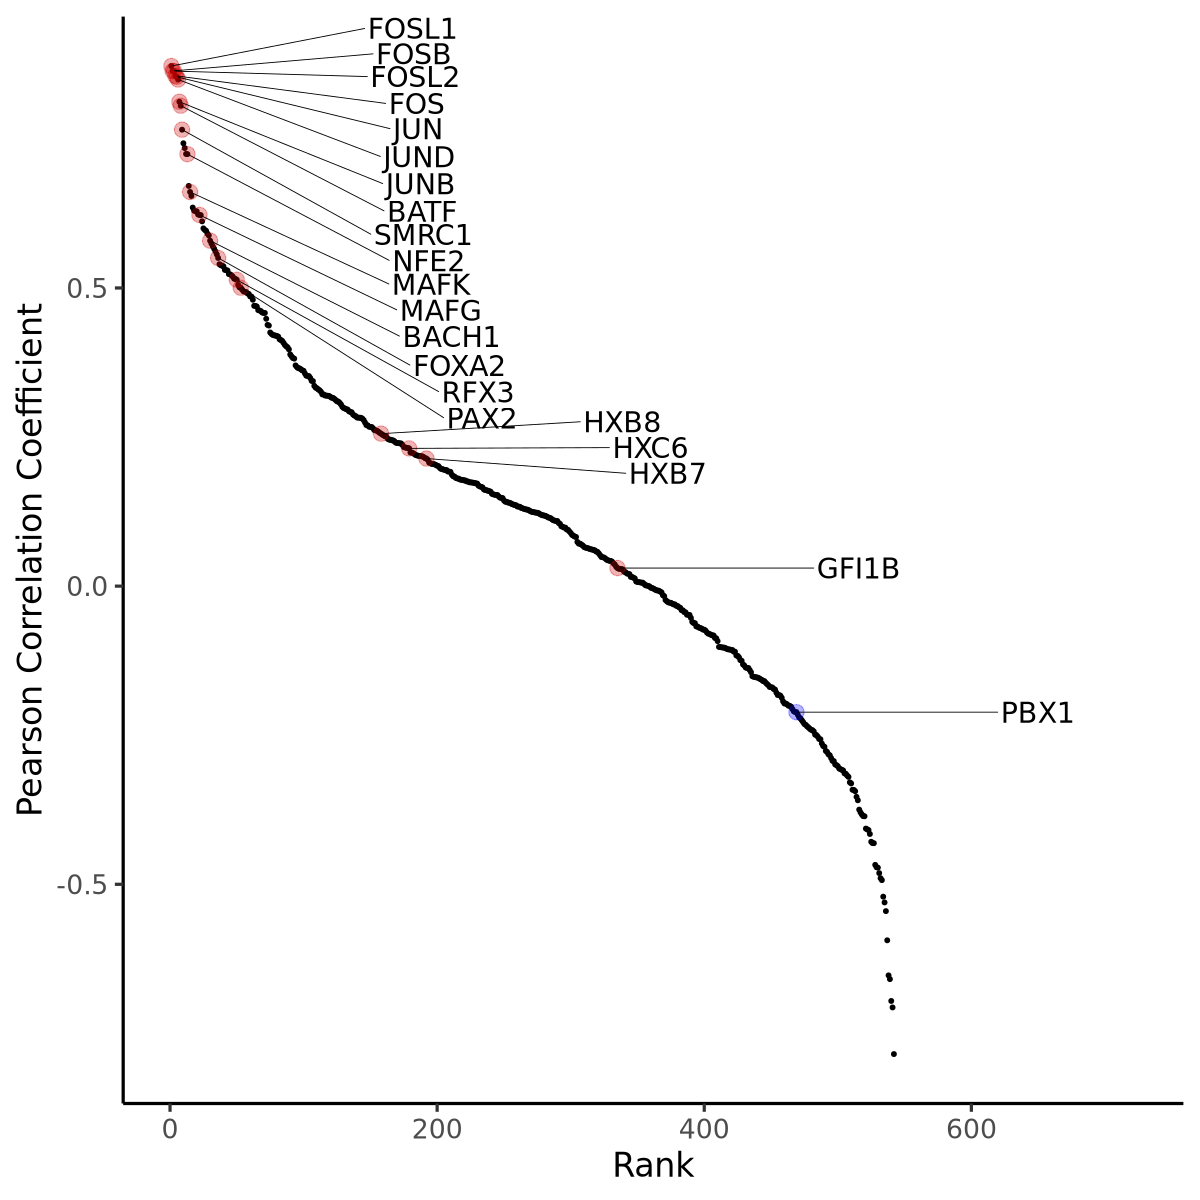

In [17]:
cell <- 'beta'

cor_motifs <- read.table(paste0('/path/to/caQTL/stuff/motifs/240424_WE_motif_QTL_pearson_',cell,'.tsv'))

options(repr.plot.width=10, repr.plot.height=10)
p1 <- ggplot(cor_motifs, aes(y=estimate, x=1:nrow(cor_motifs), label=label)) + geom_point(size=1) + 
        geom_point(alpha=cor_motifs$alpha, size=4, color=cor_motifs$col) + 
        theme_classic(base_size = 20) + labs(x='Rank', y='Pearson Correlation Coefficient') +
        ggrepel::geom_text_repel(col=c("black"), size=6, direction='y', force_pull=0,
                            segment.size=0.25, nudge_x=nrow(cor_motifs) / 3, box.padding=0.05)
p1

fp <- paste0(fig_dir,'3f_beta_motifs.svg')
svg(fp, width=10, height=10)
p1
dev.off()

# 3g - Lineage and cell type specific motifs

# TO DO ANALYSIS

# 3h - Beta example boxplot

In [18]:
#genotypes = read.table("/path/to/caQTL/stuff/caQTLs_rasqual/genotypes/All_tested_genotypes_run1.tsv", header=T)
#
#samples_all = c('R207','R217','R218','R221','R223','R226','R228','R234','R237','R238','R246','R247','R275',
#                'R284','R290','R292','R316','R317','R319','R325','R326','R327','R332','R353','R354','R362','R363')
#
#cpm_dir <- "/path/to/peaks/recluster_final_clustering_v2/"
#
#cpm_dir_files <- list.files(cpm_dir)
#cpm_dir_files[str_detect(cpm_dir_files, 'CPM')]
#
#cpm <- NULL
#for (c in main_cell_types) {
#    cpm_load <- read.table(paste0(cpm_dir, c, "_CPM_persample.txt"), header=T, row.names=1)
#    cell_specific_samples <- unlist(read.table(paste0('/path/to/caQTL/stuff/atac_cell_type_matrices/samples.',c,'.csv'), sep=','))
#    cpm_load <- cpm_load[cell_specific_samples]
#    
#    colnames(cpm_load) <- paste0(colnames(cpm_load),".",c)
#    if (is.null(cpm)) {
#        cpm <- cpm_load
#    } else {
#        cpm <- cbind(cpm, cpm_load)
#    }
#}
#
#rownames(cpm) <- str_replace(rownames(cpm), "-",":")
#
#celltypes <- c('acinar','alpha','beta','delta','ductal','endothelial','gamma',
#                'immune','stellate')
#celltypes_to_graph_bulk <- c('acinar','alpha','beta','delta','ductal','gamma', 'bulk')
#
#codir = '/data/covariates/'
#
#meta = read.table(paste0(codir, 'metadata'), sep="\t", header=T)
#meta = meta[match(samples_all, meta$Record.ID),]
#
#info = data.frame(celltype = sort(rep(celltypes, length(samples_all))), sample_name = rep( samples_all,length(celltypes)), 
#                  samp_cell = paste(rep (samples_all,length(celltypes)), sort(rep(celltypes, length(samples_all))) , sep="."),
#                   age = rep(meta$Age., length(celltypes)), sex = rep(meta$Sex.,length(celltypes)))
#
#rownames(info) <- info$samp_cell
#info <- info[colnames(cpm),]
#info <- dplyr::filter(info, celltype %in% celltypes_to_graph_bulk)

In [19]:
#gene_id = 'chr14:68585594-68586278'
#snp_id  = 'chr14:68585686:G:C'
#
#feature_snp <- paste0(gene_id, "_",snp_id)
#
#specific_cpm <- data.frame(cpm=t(cpm[gene_id,])[,1], samp_cell = rownames(t(cpm[gene_id,])))
#specific_geno <- data.frame(genotype=t(genotypes[snp_id,])[,1], sample_name=rownames(t(genotypes[snp_id,])))
#sample_data <- left_join(left_join(info, specific_cpm), specific_geno)
#
#ref <- str_split(snp_id,":", simplify=T)[,3]
#alt <- str_split(snp_id,":", simplify=T)[,4]
#sample_data$locus_genotypes <- sample_data$genotype
#sample_data$locus_genotypes <- str_replace(sample_data$locus_genotypes, "0", paste0(ref,ref))
#sample_data$locus_genotypes <- str_replace(sample_data$locus_genotypes, "1", paste0(ref,alt))
#sample_data$locus_genotypes <- str_replace(sample_data$locus_genotypes, "2", paste0(alt,alt))
#sample_data$locus_genotypes <- factor(sample_data$locus_genotypes, levels=c(paste0(ref,ref), paste0(ref,alt),paste0(alt,alt)))
#
#sample_data$celltype <- str_to_title(sample_data$celltype)
#
#write.table(sample_data, paste0(fig_dir,'3h_data_beta_caQTL_boxplot.tsv'), sep='\t', col.names=T, row.names=T, quote=F)

png 
  2

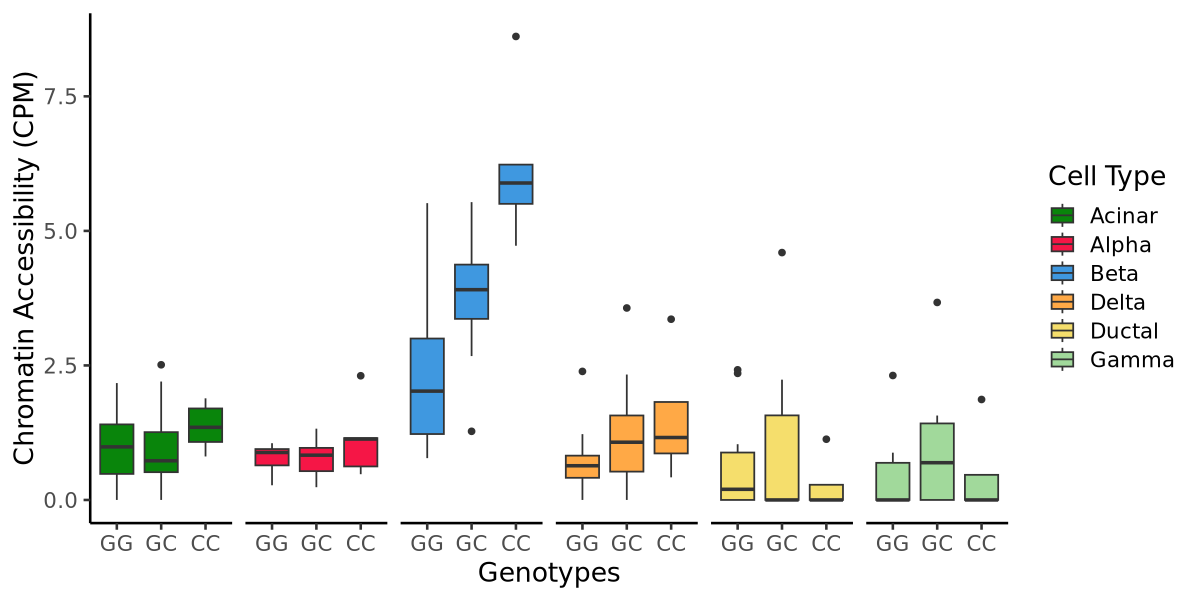

In [20]:
sample_data <- read.table(paste0(fig_dir,'3h_data_beta_caQTL_boxplot.tsv'), sep='\t', header=T)
sample_data$locus_genotypes <- factor(sample_data$locus_genotypes, levels=c('GG','GC','CC'))

options(repr.plot.width=10, repr.plot.height=5)
p1 <- ggplot(sample_data, aes(x=locus_genotypes, y=cpm, fill=celltype)) +
    geom_boxplot() + facet_grid(.~ celltype) + theme_classic(base_size=16) +
    scale_fill_manual(values=major_colors_caps) + ylab("Chromatin Accessibility (CPM)") + 
    xlab('Genotypes') + labs(fill="Cell Type") + theme(strip.background = element_blank(),
                             strip.text.y = element_blank(), strip.text.x = element_blank()) 
p1

fp <-paste0(fig_dir,'3h_beta_caQTL_boxplot.svg')
svg(fp, width=10, height=5)
p1
dev.off()

# 3i - Beta example locus zoom

In [21]:
#beta_all_caQTL <- vroom('/path/to/caQTL/stuff/caQTLs_rasqual/beta/run1/Results_run1F_all.tsv', delim='\t')
#
#beta_locus_data <- filter(beta_all_caQTL, Feature == feature)
#
#write.table(beta_locus_data, paste0(fig_dir,'3i_data_beta_caQTL_locus.tsv'), 
#    sep='\t', col.names=T, row.names=T, quote=F)

png 
  2

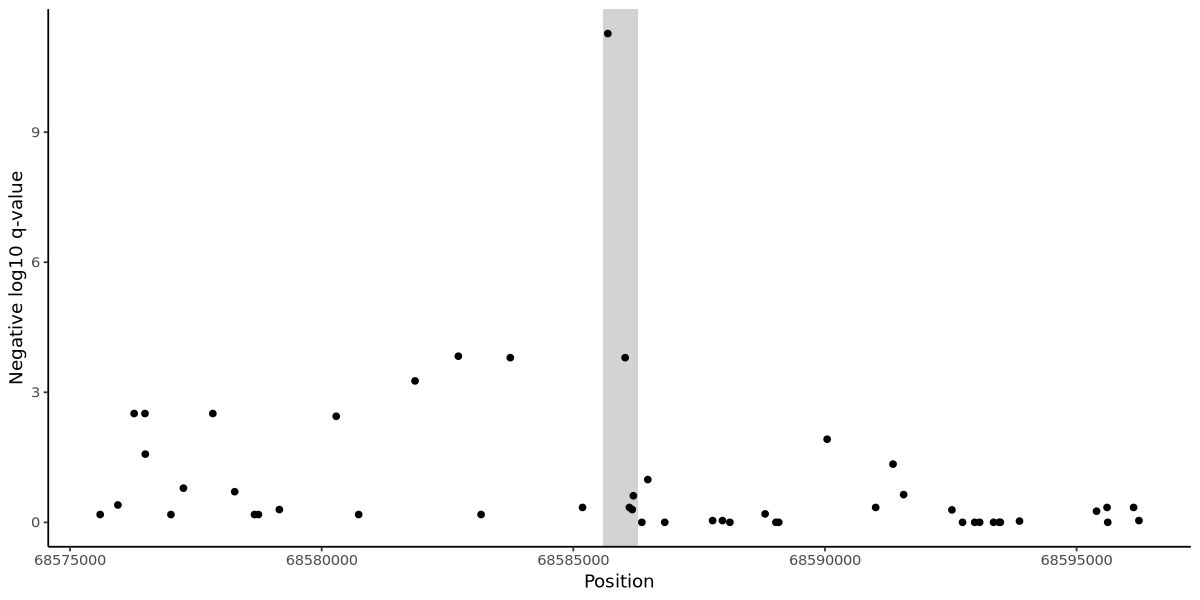

In [22]:
feature <- 'chr14:68585594-68586278'
start <- as.numeric(str_split(str_split(feature, ":", simplify=T)[2], "-", simplify=T)[1])
end <- as.numeric(str_split(str_split(feature, ":", simplify=T)[2], "-", simplify=T)[2])

beta_locus_data <- read.table(paste0(fig_dir,'3i_data_beta_caQTL_locus.tsv'), sep='\t', header=T)

options(repr.plot.width=10, repr.plot.height=5)
p1 <- ggplot(beta_locus_data, aes(x=position, y=-Log10_qval)) + 
    geom_rect(ymin=-Inf,ymax=Inf,xmin=start,xmax=end, fill='lightgrey') +
    geom_point() + 
    theme(plot.title=element_text(hjust=0.5,size=25),
              axis.title=element_text(size=20),
              axis.text.y=element_text(size=15),
              axis.text.x=element_text(angle=45, size=15, hjust=1),
              axis.ticks=element_blank(),
              #panel.border=element_rect(color='black',fill=NA, size=1),
              legend.position = "none") +
    ylab('Negative log10 q-value') + xlab('Position') + theme_classic()
p1

fp <-paste0(fig_dir,'3i_beta_caQTL_locus.svg')
svg(fp, width=10, height=5)
p1
dev.off()

# 3j - Beta example mashR effect

In [23]:
#mash_effect_full <- read.table('/path/to/caQTL/stuff/anova_interaction/240111_WE_run1_all_ash_pca_canonical_mash_PosteriorMean.tsv', 
#                                  header=T, sep='\t')
#mash_sd_full <- read.table('/path/to/caQTL/stuff/anova_interaction/240111_WE_run1_all_ash_pca_canonical_mash_PosteriorSD.tsv', 
#                                  header=T, sep='\t')
#
#gene_id = 'chr14:68585594-68586278'
#snp_id  = 'chr14:68585686:G:C'
#
#mash_effect <- mash_effect_full[paste0(gene_id,"::",snp_id),]
#mash_sd <- mash_sd_full[paste0(gene_id,"::",snp_id),]
#
#write.table(mash_effect, paste0(fig_dir,'3j_data_beta_caQTL_mash_effect.tsv'), 
#    sep='\t', col.names=T, row.names=T, quote=F)
#write.table(mash_sd, paste0(fig_dir,'3j_data_beta_caQTL_mash_sd.tsv'), 
#    sep='\t', col.names=T, row.names=T, quote=F)

png 
  2

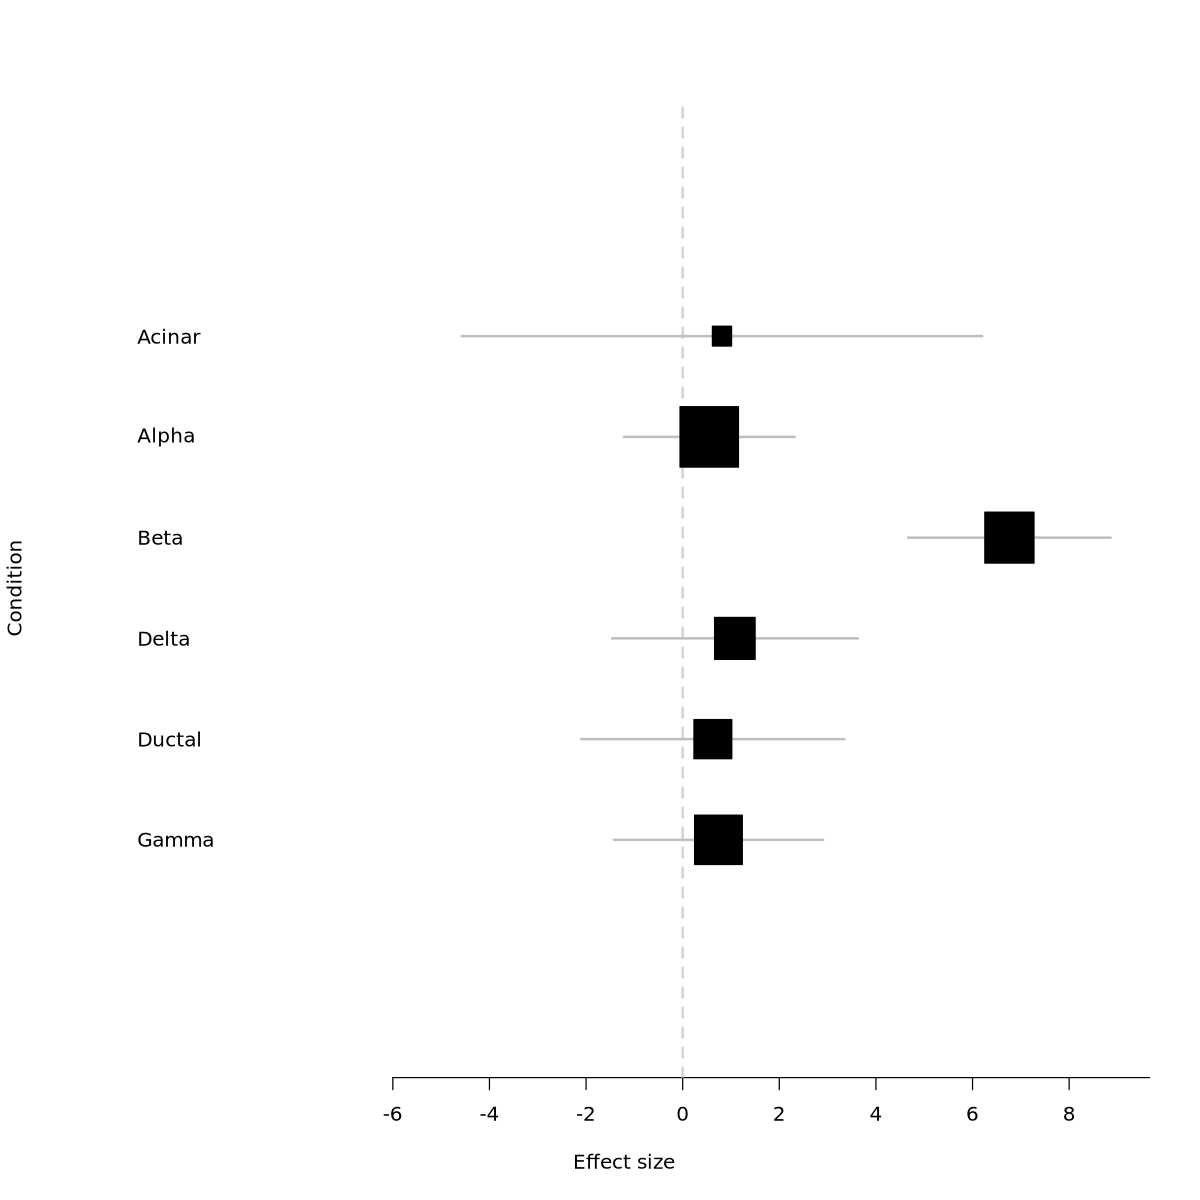

In [24]:
mash_effect <- read.table(paste0(fig_dir,'3j_data_beta_caQTL_mash_effect.tsv'), 
    sep='\t', header=T)
mash_sd <- read.table(paste0(fig_dir,'3j_data_beta_caQTL_mash_sd.tsv'), 
    sep='\t', header=T)


options(repr.plot.width=10, repr.plot.height=10)
metaplot(unlist(mash_effect),unlist(mash_sd), xlab="Effect size", 
         ylab="Condition", labels=str_to_title(colnames(mash_effect)))

fp <-paste0(fig_dir,'3j_beta_caQTL_mash_forest_plot.svg')
svg(fp, width=10, height=10)
metaplot(unlist(mash_effect),unlist(mash_sd), xlab="Effect size", 
         ylab="Condition", labels=str_to_title(colnames(mash_effect)))
dev.off()

# 3k - Beta example motifs disrupted

In [25]:
#snp_id  = 'chr14:68585686:G:C'
#snp_split <- str_split(snp_id, ":", simplify=T)
#
#write.table(data.frame(snp_split[1], (as.numeric(snp_split[2]) - 1), snp_split[2], snp_id, 0, '+'),
#            paste0(fig_dir, "3j_snp_bed.bed"), col.names=F, row.names=F, quote=F, sep='\t')
#
#snps <- snps.from.file(file = paste0(fig_dir, "3j_snp_bed.bed"),
#                       search.genome = BSgenome.Hsapiens.UCSC.hg38,format = "bed")                                 
#
#HOCOMOCOv10 <- MotifDb[mcols(MotifDb)$dataSource=='HOCOMOCOv10' & mcols(MotifDb)$organism=='Hsapiens']
#JASPAR <- MotifDb[mcols(MotifDb)$dataSource=='jaspar2018' & mcols(MotifDb)$organism=='Hsapiens']
#HOCOMOCOv11 <- MotifDb[mcols(MotifDb)$dataSource %in% c('HOCOMOCOv11-core-A', 'HOCOMOCOv11-core-B', 'HOCOMOCOv11-core-C',
#                                         'HOCOMOCOv11-secondary-A','HOCOMOCOv11-secondary-B',
#                                         'HOCOMOCOv11-secondary-C','HOCOMOCOv11-secondary-D')]
#
#test=snps[1]
#
#results_HOCOMOCOv10 <- motifbreakR(snpList = test, filterp = TRUE,
#                   pwmList = HOCOMOCOv10,
#                   method="ic",
#                   threshold = 5e-4)
#results_HOCOMOCOv10
#
#results_HOCOMOCOv11 <- motifbreakR(snpList = test, filterp = TRUE,
#                   pwmList = HOCOMOCOv11,
#                   method="ic",
#                   threshold = 5e-4)
#results_HOCOMOCOv11
#
#results_JASPAR <- motifbreakR(snpList = test, filterp = TRUE,
#                   pwmList = JASPAR,
#                   method="ic",
#                   threshold = 5e-4)
#results_JASPAR
#gc()
#
#saveRDS(results_HOCOMOCOv10, paste0(fig_dir, "3j_HOCOMOCOv10_MBR.RDS"))
#saveRDS(results_HOCOMOCOv11, paste0(fig_dir, "3j_HOCOMOCOv11_MBR.RDS"))
#saveRDS(results_JASPAR, paste0(fig_dir, "3j_JASPAR_MBR.RDS"))

In [26]:
#MBR_results <- readRDS(paste0(fig_dir, "3j_HOCOMOCOv11_MBR.RDS"))
#
#data.frame(MBR_results) %>%
#    filter(effect=='strong') %>%
#    dplyr::select(geneSymbol, alleleDiff) %>%
#    arrange(-alleleDiff)

Loading required namespace: Cairo

Warning message in checkValidSVG(doc, warn = warn):
"This picture may not have been generated by Cairo graphics; errors may result"
Loading required namespace: Cairo

Warning message in checkValidSVG(doc, warn = warn):
"This picture may not have been generated by Cairo graphics; errors may result"
Loading required namespace: Cairo

Warning message in checkValidSVG(doc, warn = warn):
"This picture may not have been generated by Cairo graphics; errors may result"
Loading required namespace: Cairo

Warning message in checkValidSVG(doc, warn = warn):
"This picture may not have been generated by Cairo graphics; errors may result"


png 
  2

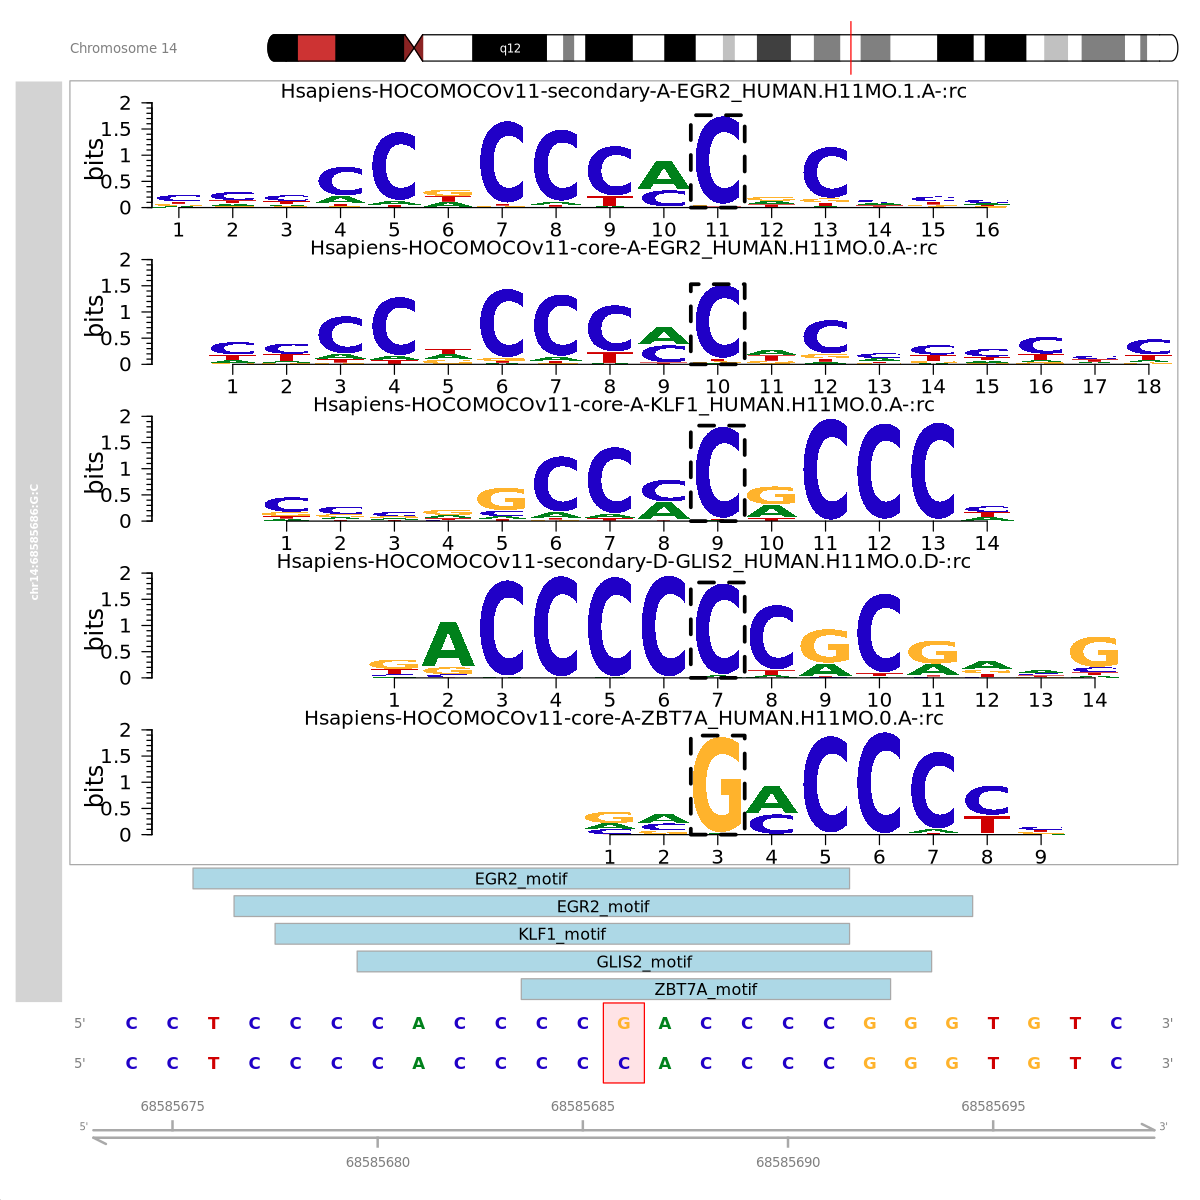

In [27]:
snp_id  = 'chr14:68585686:G:C'
snp_split <- str_split(snp_id, ":", simplify=T)
motifs <- c('KLF1','EGR2','SP8','GLIS2','ZBT7A')

MBR_results <- readRDS(paste0(fig_dir, "3j_HOCOMOCOv11_MBR.RDS"))
MBR_results <- subset(MBR_results, geneSymbol %in% motifs)

options(repr.plot.width=10, repr.plot.height=10)
plotMB(results = MBR_results, rsid = snp_id, effect = "strong")

fp <-paste0(fig_dir,'3j_beta_caQTL_motifbreakR.svg')
svg(fp, width=10, height=10)
plotMB(results = MBR_results, rsid = snp_id, effect = "strong")
dev.off()

# 3l - Acinar example boxplot

In [28]:
#genotypes = read.table("/path/to/caQTL/stuff/caQTLs_rasqual/genotypes/All_tested_genotypes_run1.tsv", header=T)
#
#samples_all = c('R207','R217','R218','R221','R223','R226','R228','R234','R237','R238','R246','R247','R275',
#                'R284','R290','R292','R316','R317','R319','R325','R326','R327','R332','R353','R354','R362','R363')
#
#cpm_dir <- "/path/to/peaks/recluster_final_clustering_v2/"
#
#cpm_dir_files <- list.files(cpm_dir)
#cpm_dir_files[str_detect(cpm_dir_files, 'CPM')]
#
#cpm <- NULL
#for (c in main_cell_types) {
#    cpm_load <- read.table(paste0(cpm_dir, c, "_CPM_persample.txt"), header=T, row.names=1)
#    cell_specific_samples <- unlist(read.table(paste0('/path/to/caQTL/stuff/atac_cell_type_matrices/samples.',c,'.csv'), sep=','))
#    cpm_load <- cpm_load[cell_specific_samples]
#    
#    colnames(cpm_load) <- paste0(colnames(cpm_load),".",c)
#    if (is.null(cpm)) {
#        cpm <- cpm_load
#    } else {
#        cpm <- cbind(cpm, cpm_load)
#    }
#}
#
#rownames(cpm) <- str_replace(rownames(cpm), "-",":")
#
#celltypes <- c('acinar','alpha','beta','delta','ductal','endothelial','gamma',
#                'immune','stellate')
#celltypes_to_graph_bulk <- c('acinar','alpha','beta','delta','ductal','gamma', 'bulk')
#
#codir = '/data/covariates/'
#
#meta = read.table(paste0(codir, 'metadata'), sep="\t", header=T)
#meta = meta[match(samples_all, meta$Record.ID),]
#
#info = data.frame(celltype = sort(rep(celltypes, length(samples_all))), sample_name = rep( samples_all,length(celltypes)), 
#                  samp_cell = paste(rep (samples_all,length(celltypes)), sort(rep(celltypes, length(samples_all))) , sep="."),
#                   age = rep(meta$Age., length(celltypes)), sex = rep(meta$Sex.,length(celltypes)))
#
#rownames(info) <- info$samp_cell
#info <- info[colnames(cpm),]
#info <- dplyr::filter(info, celltype %in% celltypes_to_graph_bulk)

In [29]:
#gene_id = 'chr16:11093379-11095519'
#snp_id  = 'chr16:11100914:C:T'
#
#feature_snp <- paste0(gene_id, "_",snp_id)
#
#specific_cpm <- data.frame(cpm=t(cpm[gene_id,])[,1], samp_cell = rownames(t(cpm[gene_id,])))
#specific_geno <- data.frame(genotype=t(genotypes[snp_id,])[,1], sample_name=rownames(t(genotypes[snp_id,])))
#sample_data <- left_join(left_join(info, specific_cpm), specific_geno)
#
#ref <- str_split(snp_id,":", simplify=T)[,3]
#alt <- str_split(snp_id,":", simplify=T)[,4]
#sample_data$locus_genotypes <- sample_data$genotype
#sample_data$locus_genotypes <- str_replace(sample_data$locus_genotypes, "0", paste0(ref,ref))
#sample_data$locus_genotypes <- str_replace(sample_data$locus_genotypes, "1", paste0(ref,alt))
#sample_data$locus_genotypes <- str_replace(sample_data$locus_genotypes, "2", paste0(alt,alt))
#sample_data$locus_genotypes <- factor(sample_data$locus_genotypes, levels=c(paste0(ref,ref), paste0(ref,alt),paste0(alt,alt)))
#
#sample_data$celltype <- str_to_title(sample_data$celltype)
#
#write.table(sample_data, paste0(fig_dir,'3l_data_acinar_caQTL_boxplot.tsv'), sep='\t', col.names=T, row.names=T, quote=F)

png 
  2

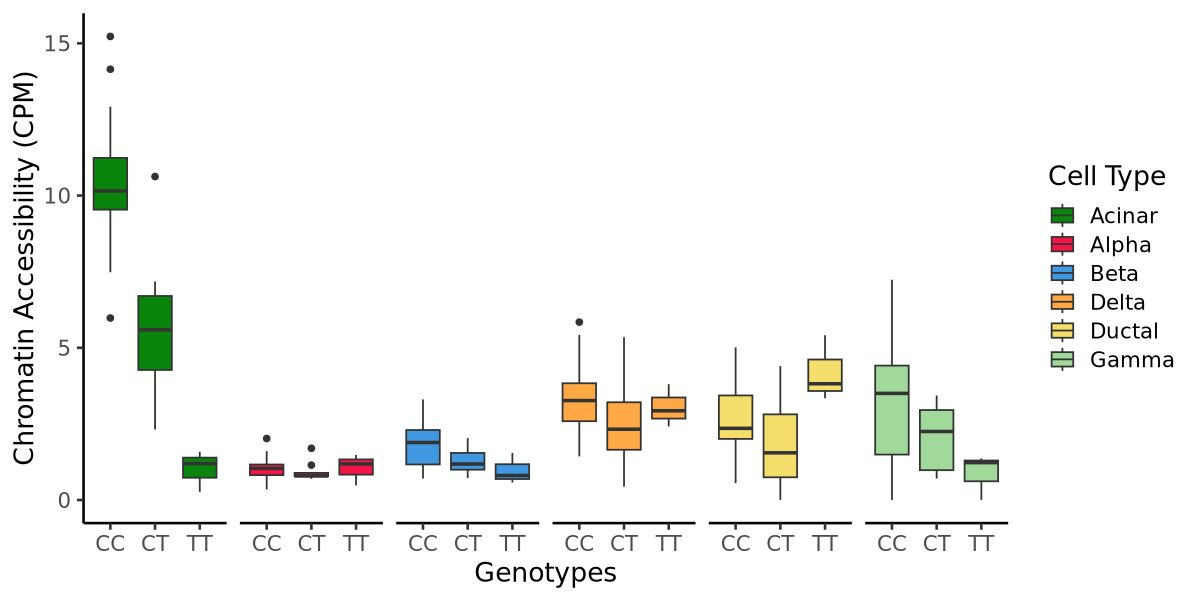

In [30]:
sample_data <- read.table(paste0(fig_dir,'3l_data_acinar_caQTL_boxplot.tsv'), sep='\t', header=T)
sample_data$locus_genotypes <- factor(sample_data$locus_genotypes, levels=c('CC','CT','TT'))

options(repr.plot.width=10, repr.plot.height=5)
p1 <- ggplot(sample_data, aes(x=locus_genotypes, y=cpm, fill=celltype)) +
    geom_boxplot() + facet_grid(.~ celltype) + theme_classic(base_size=16) +
    scale_fill_manual(values=major_colors_caps) + ylab("Chromatin Accessibility (CPM)") + 
    xlab('Genotypes') + labs(fill="Cell Type") + theme(strip.background = element_blank(),
                             strip.text.y = element_blank(), strip.text.x = element_blank()) 
p1

fp <-paste0(fig_dir,'3l_acinar_caQTL_boxplot.svg')
svg(fp, width=10, height=5)
p1
dev.off()

# 3m - Acinar example locus zoom

In [31]:
#acinar_all_caQTL <- vroom('/path/to/caQTL/stuff/caQTLs_rasqual/acinar/run1/Results_run1F_all.tsv', delim='\t')
#
#acinar_locus_data <- filter(acinar_all_caQTL, Feature == feature)
#
#write.table(acinar_locus_data, paste0(fig_dir,'3m_data_acinar_caQTL_locus.tsv'), sep='\t', col.names=T, row.names=T, quote=F)

png 
  2

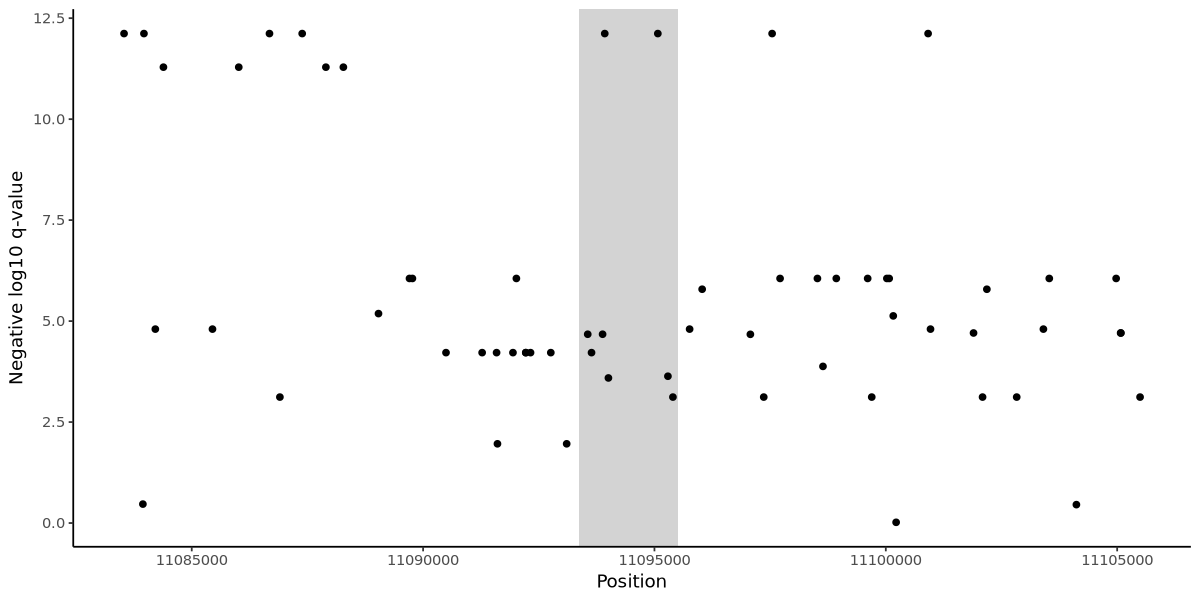

In [32]:
feature <- 'chr16:11093379-11095519'
start <- as.numeric(str_split(str_split(feature, ":", simplify=T)[2], "-", simplify=T)[1])
end <- as.numeric(str_split(str_split(feature, ":", simplify=T)[2], "-", simplify=T)[2])

acinar_locus_data <- read.table(paste0(fig_dir,'3m_data_acinar_caQTL_locus.tsv'), sep='\t', header=T)

options(repr.plot.width=10, repr.plot.height=5)
p1 <- ggplot(acinar_locus_data, aes(x=position, y=-Log10_qval)) + 
    geom_rect(ymin=-Inf,ymax=Inf,xmin=start,xmax=end, fill='lightgrey') +
    geom_point() + 
    theme(plot.title=element_text(hjust=0.5,size=25),
              axis.title=element_text(size=20),
              axis.text.y=element_text(size=15),
              axis.text.x=element_text(angle=45, size=15, hjust=1),
              axis.ticks=element_blank(),
              #panel.border=element_rect(color='black',fill=NA, size=1),
              legend.position = "none") +
    ylab('Negative log10 q-value') + xlab('Position') + theme_classic()
p1

fp <-paste0(fig_dir,'3m_acinar_caQTL_locus.svg')
svg(fp, width=10, height=5)
p1
dev.off()

# 3n - Acinar example mashR effect

In [33]:
#mash_effect_full <- read.table('/path/to/caQTL/stuff/anova_interaction/240111_WE_run1_all_ash_pca_canonical_mash_PosteriorMean.tsv', 
#                                  header=T, sep='\t')
#mash_sd_full <- read.table('/path/to/caQTL/stuff/anova_interaction/240111_WE_run1_all_ash_pca_canonical_mash_PosteriorSD.tsv', 
#                                  header=T, sep='\t')
#
#gene_id = 'chr16:11093379-11095519'
#snp_id  = 'chr16:11100914:C:T'
#
#mash_effect <- mash_effect_full[paste0(gene_id,"::",snp_id),]
#mash_sd <- mash_sd_full[paste0(gene_id,"::",snp_id),]
#
#write.table(mash_effect, paste0(fig_dir,'3n_data_acinar_caQTL_mash_effect.tsv'), 
#    sep='\t', col.names=T, row.names=T, quote=F)
#write.table(mash_sd, paste0(fig_dir,'3n_data_acinar_caQTL_mash_sd.tsv'), 
#    sep='\t', col.names=T, row.names=T, quote=F)

png 
  2

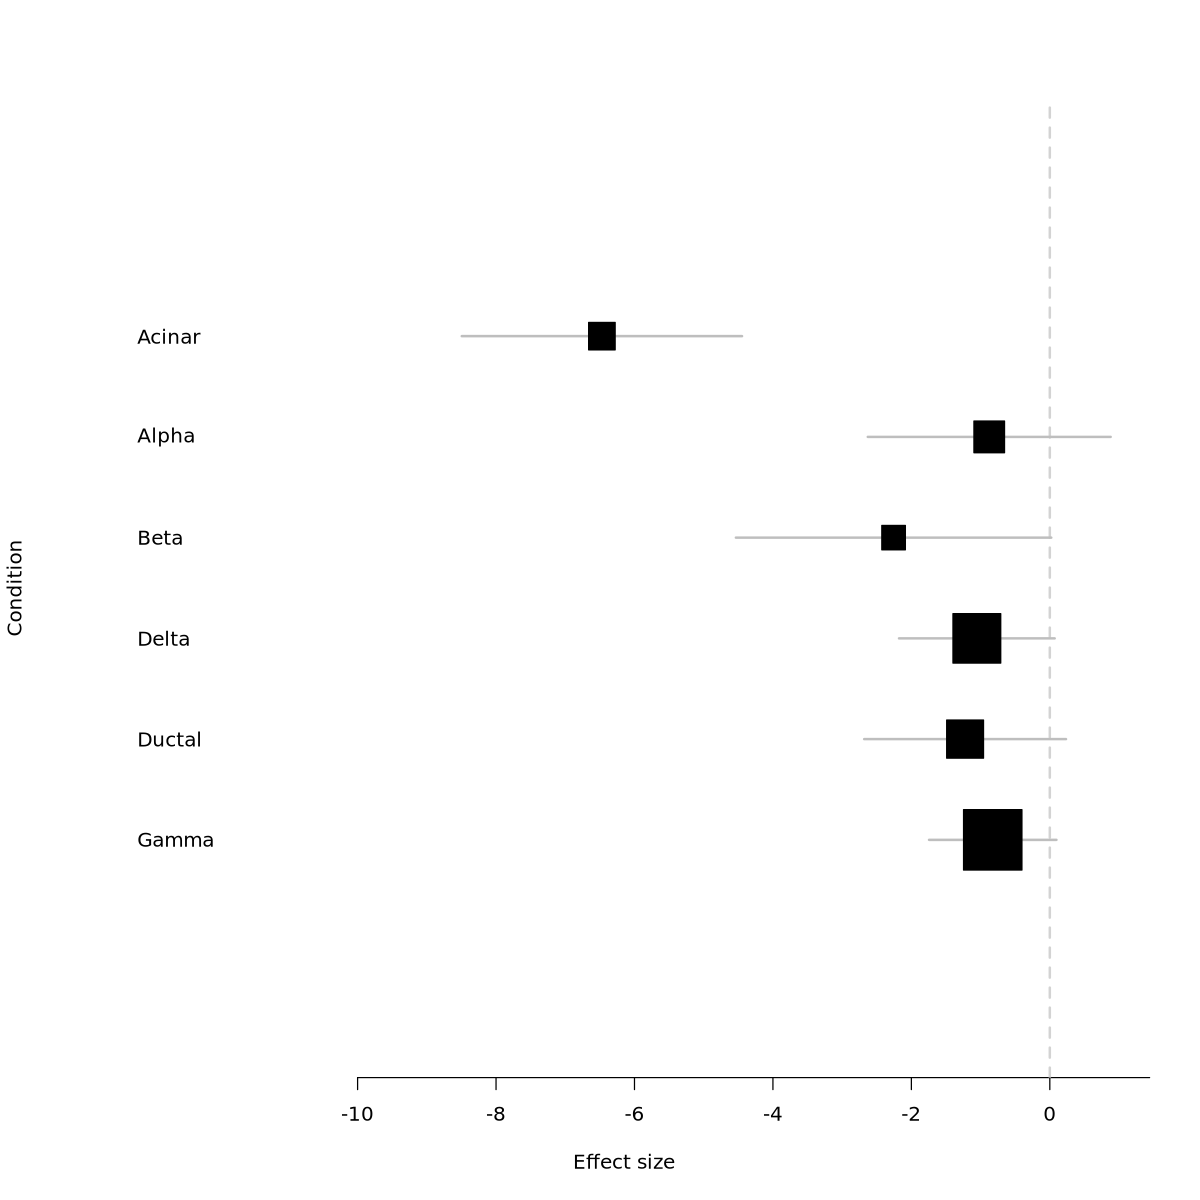

In [34]:
mash_effect <- read.table(paste0(fig_dir,'3n_data_acinar_caQTL_mash_effect.tsv'), 
    sep='\t', header=T)
mash_sd <- read.table(paste0(fig_dir,'3n_data_acinar_caQTL_mash_sd.tsv'), 
    sep='\t', header=T)


options(repr.plot.width=10, repr.plot.height=10)
metaplot(unlist(mash_effect),unlist(mash_sd), xlab="Effect size", 
         ylab="Condition", labels=str_to_title(colnames(mash_effect)))

fp <-paste0(fig_dir,'3n_acinar_caQTL_mash_forest_plot.svg')
svg(fp, width=10, height=10)
metaplot(unlist(mash_effect),unlist(mash_sd), xlab="Effect size", 
         ylab="Condition", labels=str_to_title(colnames(mash_effect)))
dev.off()

# 3o - Acinar example motifs disrupted

In [35]:
#snp_id  = 'chr16:11100914:C:T'
#snp_split <- str_split(snp_id, ":", simplify=T)
#
#write.table(data.frame(snp_split[1], (as.numeric(snp_split[2]) - 1), snp_split[2], snp_id, 0, '+'),
#            paste0(fig_dir, "3o_snp_bed.bed"), col.names=F, row.names=F, quote=F, sep='\t')
#
#snps <- snps.from.file(file = paste0(fig_dir, "3o_snp_bed.bed"),
#                       search.genome = BSgenome.Hsapiens.UCSC.hg38,format = "bed")                                 
#
#HOCOMOCOv10 <- MotifDb[mcols(MotifDb)$dataSource=='HOCOMOCOv10' & mcols(MotifDb)$organism=='Hsapiens']
#JASPAR <- MotifDb[mcols(MotifDb)$dataSource=='jaspar2018' & mcols(MotifDb)$organism=='Hsapiens']
#HOCOMOCOv11 <- MotifDb[mcols(MotifDb)$dataSource %in% c('HOCOMOCOv11-core-A', 'HOCOMOCOv11-core-B', 'HOCOMOCOv11-core-C',
#                                         'HOCOMOCOv11-secondary-A','HOCOMOCOv11-secondary-B',
#                                         'HOCOMOCOv11-secondary-C','HOCOMOCOv11-secondary-D')]
#
#test=snps[1]
#
#results_HOCOMOCOv10 <- motifbreakR(snpList = test, filterp = TRUE,
#                   pwmList = HOCOMOCOv10,
#                   method="ic",
#                   threshold = 5e-4)
#results_HOCOMOCOv10
#
#results_HOCOMOCOv11 <- motifbreakR(snpList = test, filterp = TRUE,
#                   pwmList = HOCOMOCOv11,
#                   method="ic",
#                   threshold = 5e-4)
#results_HOCOMOCOv11
#
#results_JASPAR <- motifbreakR(snpList = test, filterp = TRUE,
#                   pwmList = JASPAR,
#                   method="ic",
#                   threshold = 5e-4)
#results_JASPAR
#gc()
#
#saveRDS(results_HOCOMOCOv10, paste0(fig_dir, "3o_HOCOMOCOv10_MBR.RDS"))
#saveRDS(results_HOCOMOCOv11, paste0(fig_dir, "3o_HOCOMOCOv11_MBR.RDS"))
#saveRDS(results_JASPAR, paste0(fig_dir, "3o_JASPAR_MBR.RDS"))

In [36]:
#MBR_results <- readRDS(paste0(fig_dir, "3o_HOCOMOCOv11_MBR.RDS"))
#
#data.frame(MBR_results) %>%
#    filter(effect=='strong') %>%
#    dplyr::select(geneSymbol, alleleDiff) %>%
#    arrange(-alleleDiff)

png 
  2

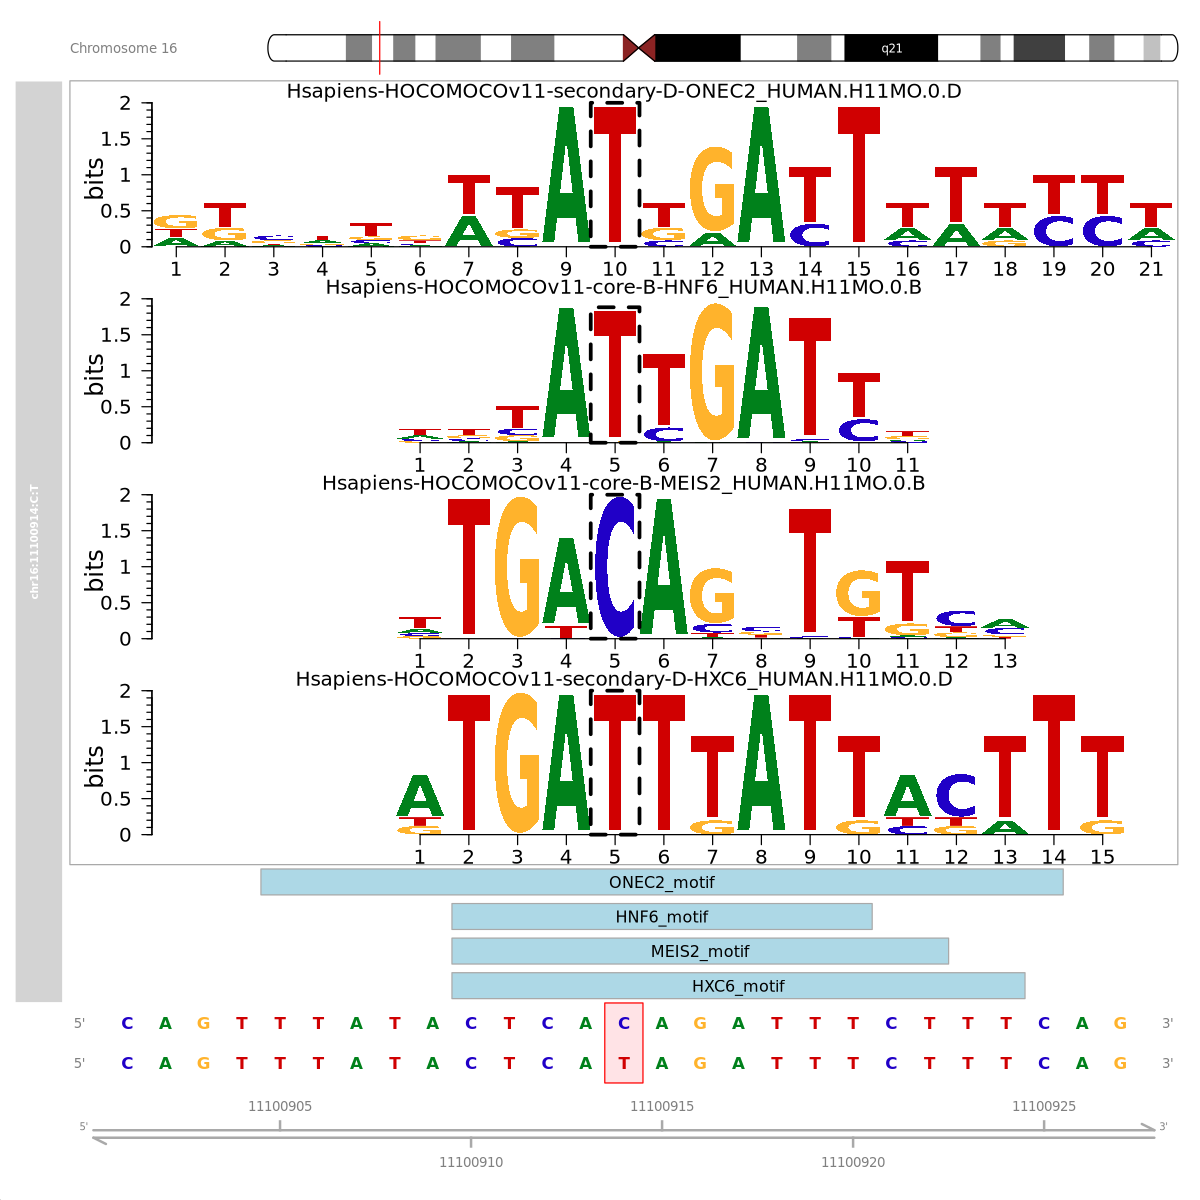

In [37]:
snp_id  = 'chr16:11100914:C:T'
snp_split <- str_split(snp_id, ":", simplify=T)
motifs <- c('HNF6','HXC6','ONEC2','MEIS2')

MBR_results <- readRDS(paste0(fig_dir, "3o_HOCOMOCOv11_MBR.RDS"))
MBR_results <- subset(MBR_results, geneSymbol %in% motifs)

options(repr.plot.width=10, repr.plot.height=10)
plotMB(results = MBR_results, rsid = snp_id, effect = "strong")

fp <-paste0(fig_dir,'3o_acinar_caQTL_motifbreakR.svg')
svg(fp, width=10, height=10)
plotMB(results = MBR_results, rsid = snp_id, effect = "strong")
dev.off()

In [8]:
snp_id  = 'chr15:70140778:G:C'
snp_split <- str_split(snp_id, ":", simplify=T)

write.table(data.frame(snp_split[1], (as.numeric(snp_split[2]) - 1), snp_split[2], snp_id, 0, '+'),
            paste0(fig_dir, "3z_snp_bed.bed"), col.names=F, row.names=F, quote=F, sep='\t')

snps <- snps.from.file(file = paste0(fig_dir, "3z_snp_bed.bed"),
                       search.genome = BSgenome.Hsapiens.UCSC.hg38,format = "bed")                                 

HOCOMOCOv10 <- MotifDb[mcols(MotifDb)$dataSource=='HOCOMOCOv10' & mcols(MotifDb)$organism=='Hsapiens']
JASPAR <- MotifDb[mcols(MotifDb)$dataSource=='jaspar2018' & mcols(MotifDb)$organism=='Hsapiens']
HOCOMOCOv11 <- MotifDb[mcols(MotifDb)$dataSource %in% c('HOCOMOCOv11-core-A', 'HOCOMOCOv11-core-B', 'HOCOMOCOv11-core-C',
                                         'HOCOMOCOv11-secondary-A','HOCOMOCOv11-secondary-B',
                                         'HOCOMOCOv11-secondary-C','HOCOMOCOv11-secondary-D')]

test=snps[1]

results_HOCOMOCOv10 <- motifbreakR(snpList = test, filterp = TRUE,
                   pwmList = HOCOMOCOv10,
                   method="ic",
                   threshold = 5e-4)
results_HOCOMOCOv10

results_HOCOMOCOv11 <- motifbreakR(snpList = test, filterp = TRUE,
                   pwmList = HOCOMOCOv11,
                   method="ic",
                   threshold = 5e-4)
results_HOCOMOCOv11

results_JASPAR <- motifbreakR(snpList = test, filterp = TRUE,
                   pwmList = JASPAR,
                   method="ic",
                   threshold = 5e-4)
results_JASPAR
gc()

saveRDS(results_HOCOMOCOv10, paste0(fig_dir, "3z_HOCOMOCOv10_MBR.RDS"))
saveRDS(results_HOCOMOCOv11, paste0(fig_dir, "3z_HOCOMOCOv11_MBR.RDS"))
saveRDS(results_JASPAR, paste0(fig_dir, "3z_JASPAR_MBR.RDS"))

GRanges object with 11 ranges and 23 metadata columns:
                     seqnames    ranges strand |             SNP_id
                        <Rle> <IRanges>  <Rle> |        <character>
  chr15:70140778:G:C    chr15  70140778      - | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      + | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      - | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      - | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      + | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      + | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      - | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      + | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      - | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      - | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      - | chr15:70140778:G:C
                                REF            ALT     varTyp

GRanges object with 15 ranges and 23 metadata columns:
                     seqnames    ranges strand |             SNP_id
                        <Rle> <IRanges>  <Rle> |        <character>
  chr15:70140778:G:C    chr15  70140778      + | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      + | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      + | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      - | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      - | chr15:70140778:G:C
                 ...      ...       ...    ... .                ...
  chr15:70140778:G:C    chr15  70140778      - | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      + | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      - | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      - | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      + | chr15:70140778:G:C
                                REF            ALT     varTyp

GRanges object with 9 ranges and 23 metadata columns:
                     seqnames    ranges strand |             SNP_id
                        <Rle> <IRanges>  <Rle> |        <character>
  chr15:70140778:G:C    chr15  70140778      - | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      - | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      + | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      - | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      + | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      + | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      - | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      + | chr15:70140778:G:C
  chr15:70140778:G:C    chr15  70140778      - | chr15:70140778:G:C
                                REF            ALT     varType motifPos
                     <DNAStringSet> <DNAStringSet> <character>   <list>
  chr15:70140778:G:C              G              C    

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,13629374,727.9,20803425,1111.1,17778167,949.5
Vcells,24939590,190.3,40386960,308.2,33585785,256.3


In [12]:
MBR_results <- readRDS(paste0(fig_dir, "3z_JASPAR_MBR.RDS"))

data.frame(MBR_results) %>%
    filter(effect=='strong') %>%
    dplyr::select(geneSymbol, alleleDiff) %>%
    arrange(-alleleDiff)

geneSymbol,alleleDiff
<chr>,<dbl>
ESR1,1.9495014
SOX10,1.6965586
NFIC::TLX1,1.5710233
PPARG,1.3855217
ESR1,1.2970517
ESR2,1.1625899
ESR2,0.9604478
ZNF143,-1.8533954
PRDM1,-1.9683903


png 
  2

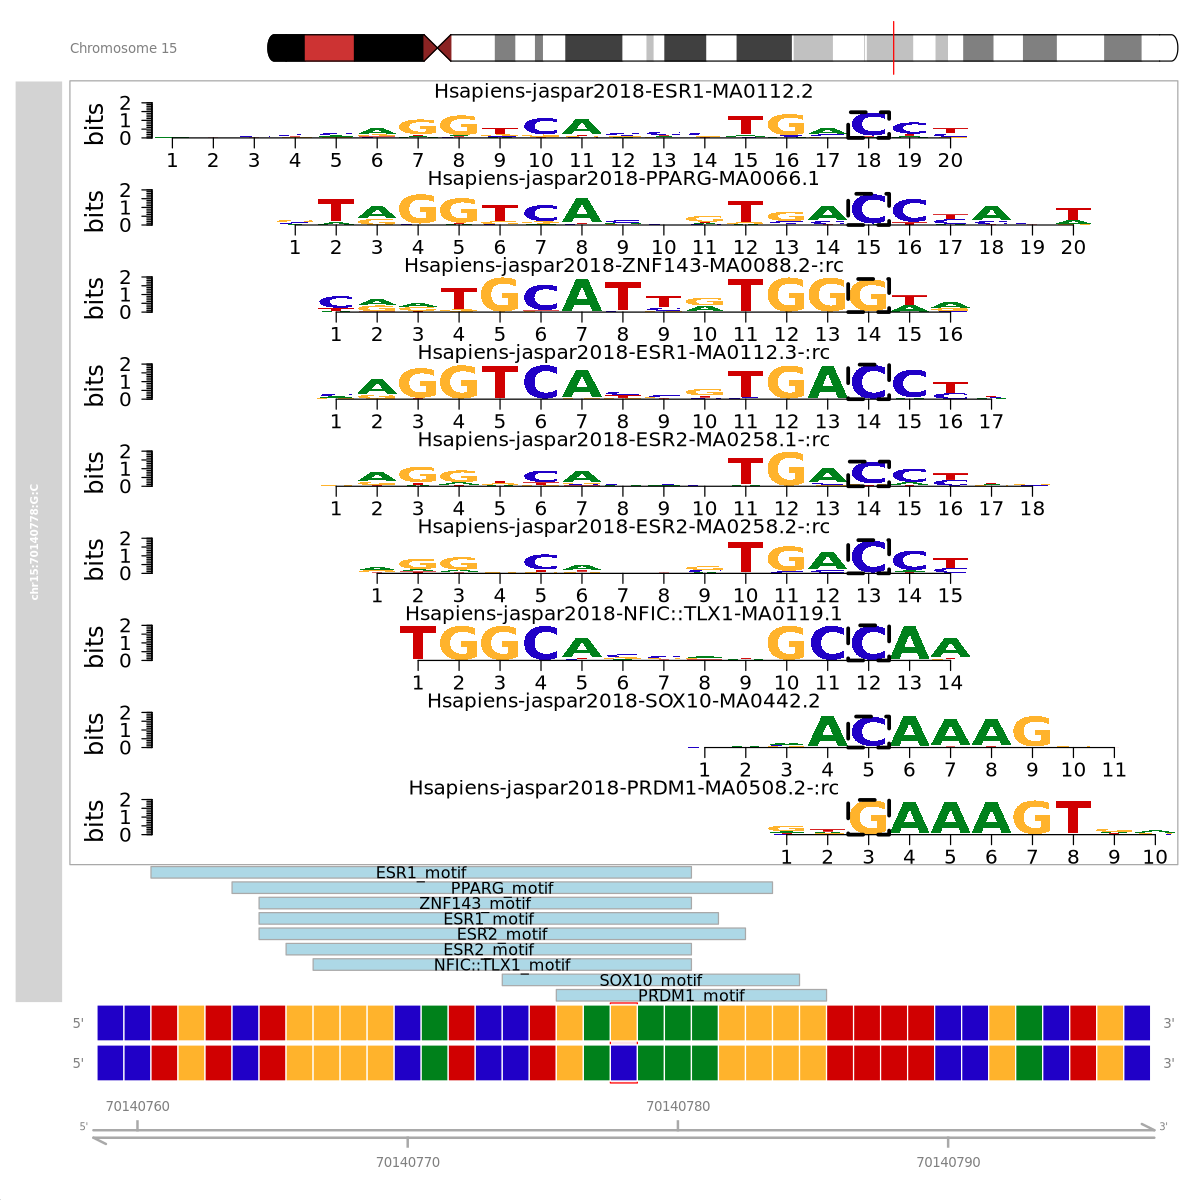

In [13]:
snp_id  = 'chr15:70140778:G:C'
snp_split <- str_split(snp_id, ":", simplify=T)
#motifs <- c('HNF6','HXC6','ONEC2','MEIS2')

MBR_results <- readRDS(paste0(fig_dir, "3z_JASPAR_MBR.RDS"))
#MBR_results <- subset(MBR_results, geneSymbol %in% motifs)

options(repr.plot.width=10, repr.plot.height=10)
plotMB(results = MBR_results, rsid = snp_id, effect = "strong")

fp <-paste0(fig_dir,'3z_acinar_caQTL_motifbreakR.svg')
svg(fp, width=10, height=10)
plotMB(results = MBR_results, rsid = snp_id, effect = "strong")
dev.off()